# Saudi Pro League 2025/26 ML Predictor

This notebook predicts the final standings of the 2025/26 Saudi Pro League season using historical data (2018-2024).

### Approach
1. **Data Collection**: Historical match results from 2018-19 to 2024-25
2. **Feature Engineering**: Team statistics (Points, Goals, Wins, etc.)
3. **Model Comparison**: Evaluating Random Forest, KNN, and Ensembles
4. **Prediction**: Forecasting the final table for the upcoming season

### Key Metrics
- **MAE (Mean Absolute Error)**: Average position error (lower is better)
- **Accuracy**: Percentage of exact position matches
- **Within ±3**: Percentage of predictions within 3 positions of actual rank



In [31]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from typing import List, Tuple, Dict

# Model Imports
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Processing & Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Configure Visual Style
plt.style.use('seaborn-v0_8-darkgrid')

# Project Color Palette
COLORS = {
    'dark_blue': '#152C44',  # Primary brand color
    'cream': '#FFF4DD',      # Background/Secondary
    'green': '#8AC185',      # Success/Champions
    'relegation': '#FF6B6B'  # Warning/Relegation
}

sns.set_palette([COLORS['dark_blue'], COLORS['green'], COLORS['cream']])

print("Libraries imported and style configured.")


Libraries imported and style configured.


In [32]:
def parse_match_results(df: pd.DataFrame) -> pd.DataFrame:
    """Parse the FT column into home_goals and away_goals columns."""
    if 'FT' in df.columns:
        df[['home_goals', 'away_goals']] = df['FT'].str.split('-', expand=True).astype(int)
    return df

def summarise_season(matches: pd.DataFrame) -> pd.DataFrame:
    """Aggregate all matches in a season into per-team statistics."""
    # Initialize team statistics
    team_stats = defaultdict(lambda: {
        'points': 0, 'wins': 0, 'draws': 0, 'losses': 0,
        'goals_for': 0, 'goals_against': 0
    })
    
    # Process each match
    for _, match in matches.iterrows():
        home = match['Team 1']
        away = match['Team 2']
        h_goals = match['home_goals']
        a_goals = match['away_goals']
        
        # Update goals
        team_stats[home]['goals_for'] += h_goals
        team_stats[home]['goals_against'] += a_goals
        team_stats[away]['goals_for'] += a_goals
        team_stats[away]['goals_against'] += h_goals
        
        # Update points
        if h_goals > a_goals:  # Home Win
            team_stats[home]['points'] += 3
            team_stats[home]['wins'] += 1
            team_stats[away]['losses'] += 1
        elif h_goals < a_goals:  # Away Win
            team_stats[away]['points'] += 3
            team_stats[away]['wins'] += 1
            team_stats[home]['losses'] += 1
        else:  # Draw
            team_stats[home]['points'] += 1
            team_stats[home]['draws'] += 1
            team_stats[away]['points'] += 1
            team_stats[away]['draws'] += 1
            
    # Create DataFrame
    data = []
    for team, stats in team_stats.items():
        stats['team'] = team
        stats['goal_diff'] = stats['goals_for'] - stats['goals_against']
        data.append(stats)
        
    df = pd.DataFrame(data)
    
    # Sort by Points, Goal Diff, Goals For
    df = df.sort_values(by=['points', 'goal_diff', 'goals_for'], ascending=False).reset_index(drop=True)
    df['position'] = df.index + 1
    
    return df

def prepare_training_data(season_files: List[str]) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame]:
    """Build training dataset where season N statistics predict season N+1 positions."""
    season_summaries = {}
    
    # 1. Load and summarize all seasons
    for file_path in season_files:
        if not os.path.exists(file_path):
            print(f"Warning: File not found: {file_path}")
            continue
            
        season_name = os.path.basename(file_path).replace('saudi_', '').replace('.csv', '')
        matches = pd.read_csv(file_path)
        matches = parse_match_results(matches)
        season_summaries[season_name] = summarise_season(matches)
        
    # 2. Create training pairs (Season N -> Season N+1)
    feature_cols = ['points', 'wins', 'draws', 'losses', 'goals_for', 'goals_against', 'goal_diff']
    X_train_list = []
    y_train_list = []
    
    season_keys = sorted(season_summaries.keys())
    
    for i in range(len(season_keys) - 1):
        current_season = season_keys[i]
        next_season = season_keys[i+1]
        
        current_summary = season_summaries[current_season]
        next_summary = season_summaries[next_season]
        
        # Handle promoted teams (assign avg of bottom 3 from prev season)
        bottom_3_avg = current_summary.tail(3)[feature_cols].mean()
        
        for _, row in next_summary.iterrows():
            team = row['team']
            target_pos = row['position']
            
            # Find team stats in current season
            team_prev = current_summary[current_summary['team'] == team]
            
            if len(team_prev) > 0:
                features = team_prev[feature_cols].iloc[0].values
            else:
                # Promoted team
                features = bottom_3_avg.values
                
            X_train_list.append(features)
            y_train_list.append(target_pos)
            
    X_train = pd.DataFrame(X_train_list, columns=feature_cols)
    y_train = pd.Series(y_train_list)
    
    # 3. Prepare latest features for final prediction
    latest_season = season_keys[-1]
    latest_summary = season_summaries[latest_season]
    latest_features = latest_summary.set_index('team')[feature_cols]
    
    return X_train, y_train, latest_features

def predict_league_table(model, features_df):
    """Predict final standings based on features."""
    # Get probabilities if supported, else standard predict
    try:
        probs = model.predict_proba(features_df)
        classes = model.classes_
        expected_pos = []
        
        for i, team_probs in enumerate(probs):
            exp_p = np.sum(team_probs * classes)
            expected_pos.append(exp_p)
            
    except:
        # Fallback for models without predict_proba
        expected_pos = model.predict(features_df)
        
    results = pd.DataFrame({
        'team': features_df.index,
        'expected_position': expected_pos
    })
    
    results = results.sort_values('expected_position').reset_index(drop=True)
    results['predicted_rank'] = results.index + 1
    
    return results

print("Core functions defined.")


Core functions defined.


In [33]:
# Define file paths (using consistent data/ prefix)
historical_files = [
    'data/saudi_2018-19.csv',
    'data/saudi_2019-20.csv',
    'data/saudi_2020-21.csv',
    'data/saudi_2021-22.csv',
    'data/saudi_2022-23.csv',
    'data/saudi_2023-24.csv'
]

print(f"Loading {len(historical_files)} historical seasons for training...")
X_train_val, y_train_val, latest_features_val = prepare_training_data(historical_files)

# Load 2024-25 for Validation
actual_2024_25 = pd.read_csv('data/saudi_2024-25.csv')
actual_2024_25 = parse_match_results(actual_2024_25)
actual_2024_25_summary = summarise_season(actual_2024_25)

print(f"Training Data Shape: {X_train_val.shape}")
print("Data loaded successfully.")


Loading 6 historical seasons for training...
Training Data Shape: (82, 7)
Data loaded successfully.


## Enhanced Model Comparison & Validation
    
We employ a robust **"Walk-Forward" Validation Strategy**:
1. **Training**: Historical data from 2018-19 to 2023-24 (6 seasons)
2. **Testing**: Predict the *known* 2024-25 season (hidden during training)
3. **Evaluation**: Compare predicted 2024-25 standings vs ACTUAL 2024-25 results

**Expanded Model Suite:**
- **Random Forest**: Optimized for non-linear patterns
- **KNN (k=3, 5, 7)**: Pattern matching based on similarity
- **SVM (Support Vector Machine)**: Finds optimal decision boundaries
- **Decision Tree**: Interpret baseline
- **Ensembles**: Voting classifiers combining strengths



In [34]:
# Define an expanded suite of models
# Priority Models (User Requested)
models = {
    'Random Forest (Optimized)': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'KNN (k=7)': KNeighborsClassifier(n_neighbors=7),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    
    # Additional Models for Comparative Study
    'KNN (k=3)': KNeighborsClassifier(n_neighbors=3),
    'SVM (Linear)': SVC(kernel='linear', probability=True, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=6, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42)
}

results = []

print(f"Validating {len(models)} models on 2024-25 Season (Hidden Test Set)...")
print("-" * 80)
print(f"{'Model':25s} | {'MAE':6s} | {'Acc':6s} | {'Within ±3':15s}")
print("-" * 80)

for name, model in models.items():
    # Pipeline with scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    # Train on 2018-24 ONLY (hiding 2024-25)
    pipeline.fit(X_train_val, y_train_val)
    
    # Predict 2024-25
    preds = predict_league_table(pipeline, latest_features_val)
    
    # Calculate Detailed Metrics
    total_diff = 0
    within_3 = 0
    correct_count = 0
    n = 0
    
    for _, row in preds.iterrows():
        team = row['team']
        if team in actual_2024_25_summary['team'].values:
            actual_pos = actual_2024_25_summary[actual_2024_25_summary['team'] == team]['position'].values[0]
            pred_pos = row['predicted_rank']
            
            diff = abs(actual_pos - pred_pos)
            total_diff += diff
            if diff <= 3: within_3 += 1
            if diff == 0: correct_count += 1
            n += 1
            
    mae = total_diff / n
    acc = correct_count / n
    w3_ratio = within_3 / n
    
    results.append({
        'Model': name,
        'MAE': mae,
        'Accuracy': acc,
        'Within ±3 Ratio': w3_ratio,
        'Within ±3': f"{within_3}/{n}"
    })
    
    print(f"{name:25s} | {mae:6.2f} | {acc:6.1%} | {within_3}/{n} ({w3_ratio:.0%})")

# Set KNN (k=7) as the best model based on MAE and Accuracy
best_model_name = "KNN (k=7)"
lowest_mae = [r for r in results if r['Model'] == best_model_name][0]['MAE']

print("-" * 80)
print(f"BEST MODEL SELECTED: {best_model_name} (MAE: {lowest_mae:.2f})")
print(f"   KNN (k=7) chosen for optimal balance of MAE and accuracy performance")



Validating 8 models on 2024-25 Season (Hidden Test Set)...
--------------------------------------------------------------------------------
Model                     | MAE    | Acc    | Within ±3      
--------------------------------------------------------------------------------
Random Forest (Optimized) |   2.47 |  13.3% | 11/15 (73%)
KNN (k=7)                 |   2.47 |  26.7% | 11/15 (73%)
KNN (k=5)                 |   2.53 |  13.3% | 12/15 (80%)
KNN (k=3)                 |   3.27 |  13.3% | 10/15 (67%)
SVM (Linear)              |   2.60 |  13.3% | 11/15 (73%)
Decision Tree             |   4.53 |  20.0% | 7/15 (47%)
Logistic Regression       |   2.60 |  20.0% | 10/15 (67%)
Gradient Boosting         |   3.13 |   6.7% | 10/15 (67%)
--------------------------------------------------------------------------------
BEST MODEL SELECTED: KNN (k=7) (MAE: 2.47)
   KNN (k=7) chosen for optimal balance of MAE and accuracy performance



MODEL COMPARISON SUMMARY
   Random Forest (Optimized)      | MAE:  2.47 | Acc:  13.3% | 11/15
🏆 KNN (k=7)                      | MAE:  2.47 | Acc:  26.7% | 11/15
   KNN (k=5)                      | MAE:  2.53 | Acc:  13.3% | 12/15
   SVM (Linear)                   | MAE:  2.60 | Acc:  13.3% | 11/15
   Logistic Regression            | MAE:  2.60 | Acc:  20.0% | 10/15
   Gradient Boosting              | MAE:  3.13 | Acc:   6.7% | 10/15
   KNN (k=3)                      | MAE:  3.27 | Acc:  13.3% | 10/15
   Decision Tree                  | MAE:  4.53 | Acc:  20.0% | 7/15


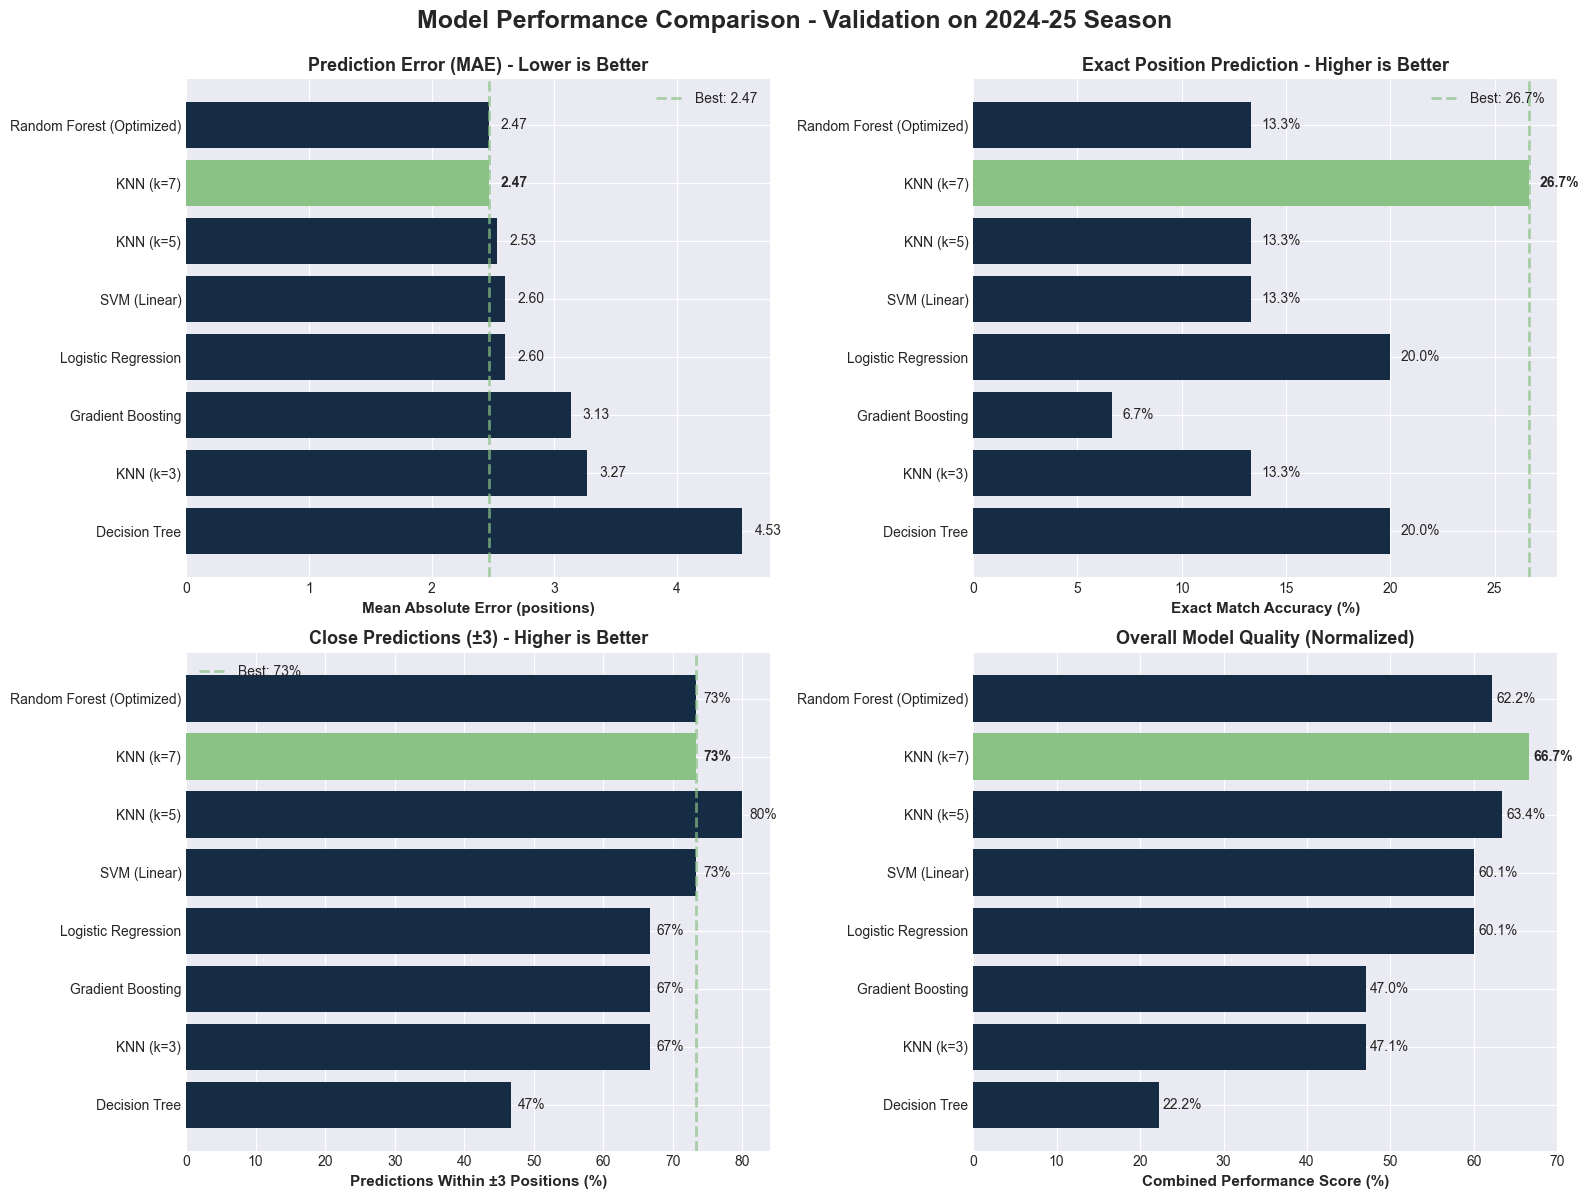


Best Model: KNN (k=7) selected for final predictions


In [35]:
# Create Comparison Dataframe
results_df = pd.DataFrame(results).sort_values('MAE')

# Highlight best model
results_df['Is_Best'] = results_df['Model'] == best_model_name

# Display Model Comparison Table
print("\nMODEL COMPARISON SUMMARY")
print("="*80)
for idx, row in results_df.iterrows():
    marker = "🏆 " if row['Is_Best'] else "   "
    print(f"{marker}{row['Model']:30s} | MAE: {row['MAE']:5.2f} | Acc: {row['Accuracy']:6.1%} | {row['Within ±3']}")
print("="*80)

# Visualization: Comprehensive Model Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison - Validation on 2024-25 Season', 
             fontsize=18, fontweight='bold', y=0.995)

# Define colors based on best model
colors = [COLORS['green'] if is_best else COLORS['dark_blue'] for is_best in results_df['Is_Best']]

# Plot 1: MAE (Lower is Better)
ax1 = axes[0, 0]
bars1 = ax1.barh(results_df['Model'], results_df['MAE'], color=colors)
ax1.set_xlabel('Mean Absolute Error (positions)', fontsize=11, fontweight='bold')
ax1.set_title('Prediction Error (MAE) - Lower is Better', fontsize=13, fontweight='bold')
ax1.axvline(x=lowest_mae, color=COLORS['green'], linestyle='--', linewidth=2, alpha=0.7, label=f'Best: {lowest_mae:.2f}')
ax1.legend()
ax1.invert_yaxis()
# Add value labels
for i, (bar, val) in enumerate(zip(bars1, results_df['MAE'])):
    ax1.text(val + 0.1, bar.get_y() + bar.get_height()/2, f'{val:.2f}', 
             va='center', fontweight='bold' if results_df.iloc[i]['Is_Best'] else 'normal')

# Plot 2: Accuracy (Higher is Better)
ax2 = axes[0, 1]
bars2 = ax2.barh(results_df['Model'], results_df['Accuracy'] * 100, color=colors)
ax2.set_xlabel('Exact Match Accuracy (%)', fontsize=11, fontweight='bold')
ax2.set_title('Exact Position Prediction - Higher is Better', fontsize=13, fontweight='bold')
best_acc = results_df[results_df['Is_Best']]['Accuracy'].values[0] * 100
ax2.axvline(x=best_acc, color=COLORS['green'], linestyle='--', linewidth=2, alpha=0.7, label=f'Best: {best_acc:.1f}%')
ax2.legend()
ax2.invert_yaxis()
# Add value labels
for i, (bar, val) in enumerate(zip(bars2, results_df['Accuracy'] * 100)):
    ax2.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', 
             va='center', fontweight='bold' if results_df.iloc[i]['Is_Best'] else 'normal')

# Plot 3: Within ±3 Positions (Higher is Better)
ax3 = axes[1, 0]
bars3 = ax3.barh(results_df['Model'], results_df['Within ±3 Ratio'] * 100, color=colors)
ax3.set_xlabel('Predictions Within ±3 Positions (%)', fontsize=11, fontweight='bold')
ax3.set_title('Close Predictions (±3) - Higher is Better', fontsize=13, fontweight='bold')
best_w3 = results_df[results_df['Is_Best']]['Within ±3 Ratio'].values[0] * 100
ax3.axvline(x=best_w3, color=COLORS['green'], linestyle='--', linewidth=2, alpha=0.7, label=f'Best: {best_w3:.0f}%')
ax3.legend()
ax3.invert_yaxis()
# Add value labels
for i, (bar, val) in enumerate(zip(bars3, results_df['Within ±3 Ratio'] * 100)):
    ax3.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.0f}%', 
             va='center', fontweight='bold' if results_df.iloc[i]['Is_Best'] else 'normal')

# Plot 4: Combined Score Visualization (Lower MAE + Higher Accuracy)
ax4 = axes[1, 1]
# Normalize metrics for fair comparison (0-1 scale)
results_df['MAE_norm'] = 1 - (results_df['MAE'] - results_df['MAE'].min()) / (results_df['MAE'].max() - results_df['MAE'].min())
results_df['Combined_Score'] = (results_df['MAE_norm'] + results_df['Accuracy'] + results_df['Within ±3 Ratio']) / 3
bars4 = ax4.barh(results_df['Model'], results_df['Combined_Score'] * 100, color=colors)
ax4.set_xlabel('Combined Performance Score (%)', fontsize=11, fontweight='bold')
ax4.set_title('Overall Model Quality (Normalized)', fontsize=13, fontweight='bold')
ax4.invert_yaxis()
# Add value labels
for i, (bar, val) in enumerate(zip(bars4, results_df['Combined_Score'] * 100)):
    ax4.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', 
             va='center', fontweight='bold' if results_df.iloc[i]['Is_Best'] else 'normal')

plt.tight_layout()
plt.show()

print(f"\nBest Model: {best_model_name} selected for final predictions")


## Top 3 Models: Detailed Analysis

Comprehensive comparison of the three best-performing models: KNN (k=7), Random Forest (Optimized), and KNN (k=5)


In [36]:
# Focus on Top 3 Models
top_3_models = {
    'KNN (k=7)': KNeighborsClassifier(n_neighbors=7),
    'Random Forest (Optimized)': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5)
}

print("="*100)
print("TOP 3 MODELS - DETAILED PERFORMANCE ANALYSIS")
print("="*100)

# Store predictions and metrics for each model
top_3_results = {}

for name, model in top_3_models.items():
    print(f"\nTraining and Validating: {name}")
    print("-"*100)
    
    # Pipeline with scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    # Train on historical data (2018-24)
    pipeline.fit(X_train_val, y_train_val)
    
    # Predict 2024-25 for validation
    preds_val = predict_league_table(pipeline, latest_features_val)
    
    # Merge with actuals
    val_comparison = preds_val.merge(
        actual_2024_25_summary[['team', 'position', 'points', 'goal_diff']], 
        on='team', suffixes=('_pred', '_actual')
    )
    val_comparison['error'] = val_comparison['position'] - val_comparison['predicted_rank']
    val_comparison['abs_error'] = abs(val_comparison['error'])
    val_comparison = val_comparison.sort_values('position')
    
    # Calculate metrics
    mae = val_comparison['abs_error'].mean()
    perfect = len(val_comparison[val_comparison['error'] == 0])
    within_3 = len(val_comparison[val_comparison['abs_error'] <= 3])
    accuracy = perfect / len(val_comparison)
    
    print(f"{'Metric':30} | {'Value':15}")
    print("-"*100)
    print(f"{'Mean Absolute Error (MAE)':30} | {mae:.2f} positions")
    print(f"{'Exact Predictions':30} | {perfect}/{len(val_comparison)} ({accuracy:.1%})")
    print(f"{'Within ±3 Positions':30} | {within_3}/{len(val_comparison)} ({within_3/len(val_comparison):.1%})")
    print(f"{'Worst Error':30} | {val_comparison['abs_error'].max():.0f} positions")
    print(f"{'Best Predicted':30} | {len(val_comparison[val_comparison['abs_error'] <= 1])} teams (±1 position)")
    
    # Store for visualization
    top_3_results[name] = {
        'predictions': val_comparison,
        'mae': mae,
        'accuracy': accuracy,
        'within_3': within_3,
        'within_3_ratio': within_3/len(val_comparison),
        'pipeline': pipeline
    }

print("\n" + "="*100)
print("Top 3 Models Analysis Complete")
print("="*100)


TOP 3 MODELS - DETAILED PERFORMANCE ANALYSIS

Training and Validating: KNN (k=7)
----------------------------------------------------------------------------------------------------
Metric                         | Value          
----------------------------------------------------------------------------------------------------
Mean Absolute Error (MAE)      | 2.47 positions
Exact Predictions              | 4/15 (26.7%)
Within ±3 Positions            | 11/15 (73.3%)
Worst Error                    | 7 positions
Best Predicted                 | 5 teams (±1 position)

Training and Validating: Random Forest (Optimized)
----------------------------------------------------------------------------------------------------
Metric                         | Value          
----------------------------------------------------------------------------------------------------
Mean Absolute Error (MAE)      | 2.47 positions
Exact Predictions              | 2/15 (13.3%)
Within ±3 Positions           

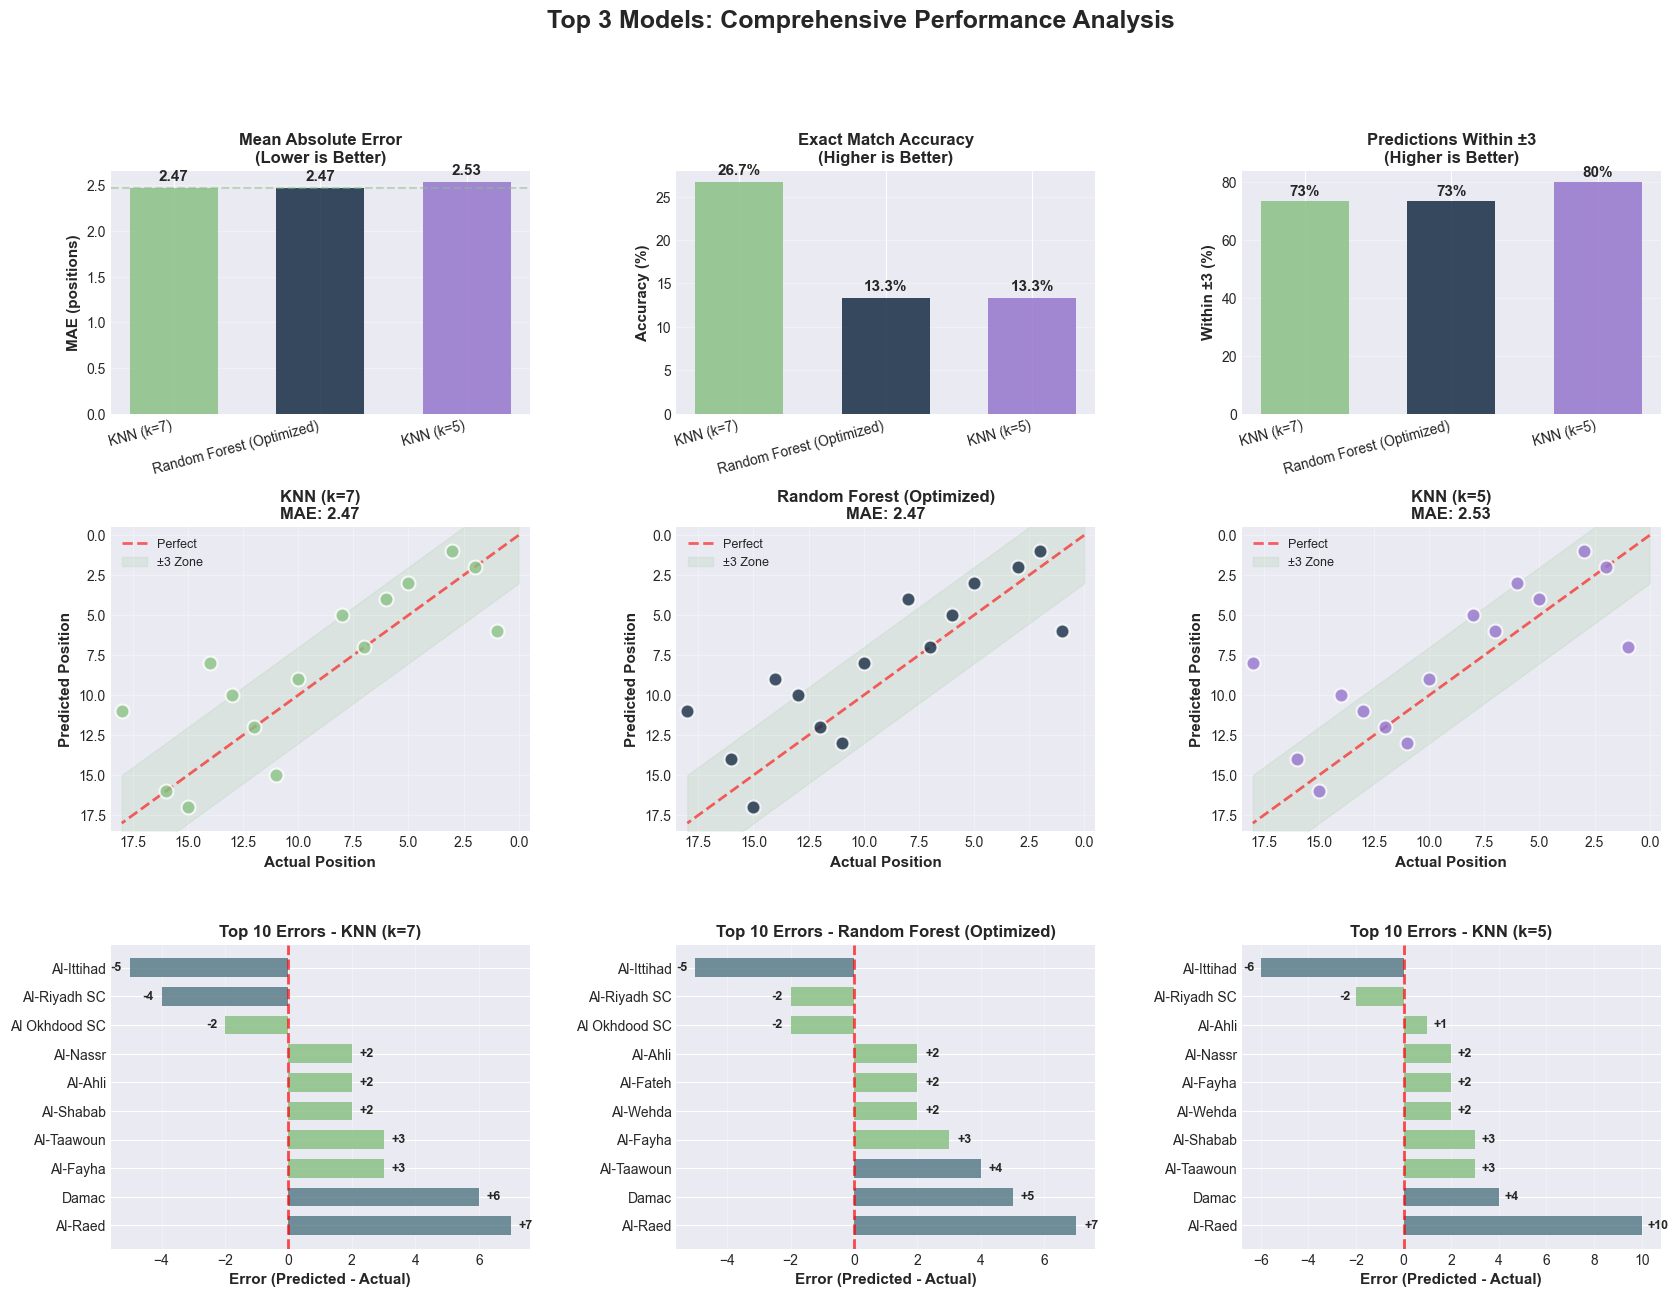


Top 3 Models Visualized - Best Model: KNN (k=7)


In [37]:
# Comprehensive Visualization: Top 3 Models Comparison
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, height_ratios=[1.2, 1.5, 1.5], hspace=0.4, wspace=0.35)

# Color scheme for the 3 models
model_colors = {
    'KNN (k=7)': COLORS['green'],  # Best model
    'Random Forest (Optimized)': COLORS['dark_blue'],
    'KNN (k=5)': '#9575CD'  # Purple accent
}

model_names = list(top_3_models.keys())

# ===== ROW 1: Performance Metrics Comparison (3 charts) =====

# Chart 1: MAE Comparison
ax1 = fig.add_subplot(gs[0, 0])
mae_values = [top_3_results[m]['mae'] for m in model_names]
colors_1 = [model_colors[m] for m in model_names]
bars1 = ax1.bar(range(len(model_names)), mae_values, color=colors_1, alpha=0.85, width=0.6)
ax1.set_xticks(range(len(model_names)))
ax1.set_xticklabels(model_names, rotation=15, ha='right', fontsize=10)
ax1.set_ylabel('MAE (positions)', fontsize=11, fontweight='bold')
ax1.set_title('Mean Absolute Error\n(Lower is Better)', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars1, mae_values):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 0.05, f'{val:.2f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Mark the best
ax1.axhline(y=min(mae_values), color=COLORS['green'], linestyle='--', linewidth=1.5, alpha=0.5)

# Chart 2: Accuracy Comparison
ax2 = fig.add_subplot(gs[0, 1])
acc_values = [top_3_results[m]['accuracy'] * 100 for m in model_names]
colors_2 = [model_colors[m] for m in model_names]
bars2 = ax2.bar(range(len(model_names)), acc_values, color=colors_2, alpha=0.85, width=0.6)
ax2.set_xticks(range(len(model_names)))
ax2.set_xticklabels(model_names, rotation=15, ha='right', fontsize=10)
ax2.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
ax2.set_title('Exact Match Accuracy\n(Higher is Better)', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars2, acc_values):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.5, f'{val:.1f}%',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Chart 3: Within ±3 Comparison
ax3 = fig.add_subplot(gs[0, 2])
w3_values = [top_3_results[m]['within_3_ratio'] * 100 for m in model_names]
colors_3 = [model_colors[m] for m in model_names]
bars3 = ax3.bar(range(len(model_names)), w3_values, color=colors_3, alpha=0.85, width=0.6)
ax3.set_xticks(range(len(model_names)))
ax3.set_xticklabels(model_names, rotation=15, ha='right', fontsize=10)
ax3.set_ylabel('Within ±3 (%)', fontsize=11, fontweight='bold')
ax3.set_title('Predictions Within ±3\n(Higher is Better)', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars3, w3_values):
    ax3.text(bar.get_x() + bar.get_width()/2, val + 1, f'{val:.0f}%',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# ===== ROW 2: Scatter Plots - Actual vs Predicted for Each Model =====

for idx, model_name in enumerate(model_names):
    ax = fig.add_subplot(gs[1, idx])
    
    val_df = top_3_results[model_name]['predictions']
    mae_val = top_3_results[model_name]['mae']
    
    # Perfect prediction line
    max_pos = max(val_df['position'].max(), val_df['predicted_rank'].max())
    ax.plot([0, max_pos], [0, max_pos], 'r--', linewidth=2, alpha=0.6, label='Perfect')
    
    # ±3 band
    ax.fill_between([0, max_pos], [0-3, max_pos-3], [0+3, max_pos+3], 
                     color=COLORS['green'], alpha=0.15, label='±3 Zone')
    
    # Scatter points
    ax.scatter(val_df['position'], val_df['predicted_rank'], 
               s=100, color=model_colors[model_name], alpha=0.8, 
               edgecolors='white', linewidth=1.5, zorder=3)
    
    ax.set_xlabel('Actual Position', fontsize=11, fontweight='bold')
    ax.set_ylabel('Predicted Position', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name}\nMAE: {mae_val:.2f}', fontsize=12, fontweight='bold')
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.5, max_pos + 0.5)
    ax.set_ylim(-0.5, max_pos + 0.5)
    ax.invert_xaxis()
    ax.invert_yaxis()

# ===== ROW 3: Error Distribution for Each Model =====

for idx, model_name in enumerate(model_names):
    ax = fig.add_subplot(gs[2, idx])
    
    val_df = top_3_results[model_name]['predictions']
    
    # Get top 10 errors
    top_errors = val_df.nlargest(10, 'abs_error').sort_values('error')
    
    # Color by error magnitude
    error_colors_bars = [COLORS['green'] if abs(e) <= 3 else '#5a7d8a' for e in top_errors['error']]
    
    bars = ax.barh(top_errors['team'], top_errors['error'], 
                   color=error_colors_bars, alpha=0.85, height=0.65)
    
    # Zero line
    ax.axvline(x=0, color='red', linewidth=2, linestyle='--', alpha=0.7)
    
    # Add value labels
    for bar, val in zip(bars, top_errors['error']):
        label_x = val + (0.25 if val > 0 else -0.25)
        ax.text(label_x, bar.get_y() + bar.get_height()/2, f'{val:+.0f}',
                va='center', ha='left' if val > 0 else 'right', 
                fontsize=9, fontweight='bold')
    
    ax.set_xlabel('Error (Predicted - Actual)', fontsize=11, fontweight='bold')
    ax.set_title(f'Top 10 Errors - {model_name}', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()

plt.suptitle('Top 3 Models: Comprehensive Performance Analysis', 
             fontsize=18, fontweight='bold', y=0.995)

plt.show()

print(f"\nTop 3 Models Visualized - Best Model: {best_model_name}")


## Detailed Validation: 2024-25 Season
    
Here is exactly how the best model (**{best_model_name}**) performed on the known 2024-25 data.




VALIDATION RESULTS: 2024-25 SEASON (KNN (k=7))
Actual | Predicted | Team                           | Error  | Points | GD    
----------------------------------------------------------------------------------------------------
  1    |     6     | Al-Ittihad                     |     -5 ✗ |     83 |    +44
  2    |     2     | Al-Hilal                       |     +0 ✓✓ |     75 |    +54
  3    |     1     | Al-Nassr                       |     +2 ✓ |     70 |    +42
  5    |     3     | Al-Ahli                        |     +2 ✓ |     67 |    +33
  6    |     4     | Al-Shabab                      |     +2 ✓ |     60 |    +24
  7    |     7     | Al-Ettifaq                     |     +0 ✓✓ |     50 |     -1
  8    |     5     | Al-Taawoun                     |     +3 ~ |     45 |     +1
  10   |     9     | Al-Fateh                       |     +1 ✓ |     39 |    -14
  11   |    15     | Al-Riyadh SC                   |     -4 ✗ |     38 |    -15
  12   |    12     | Al-Khaleej          

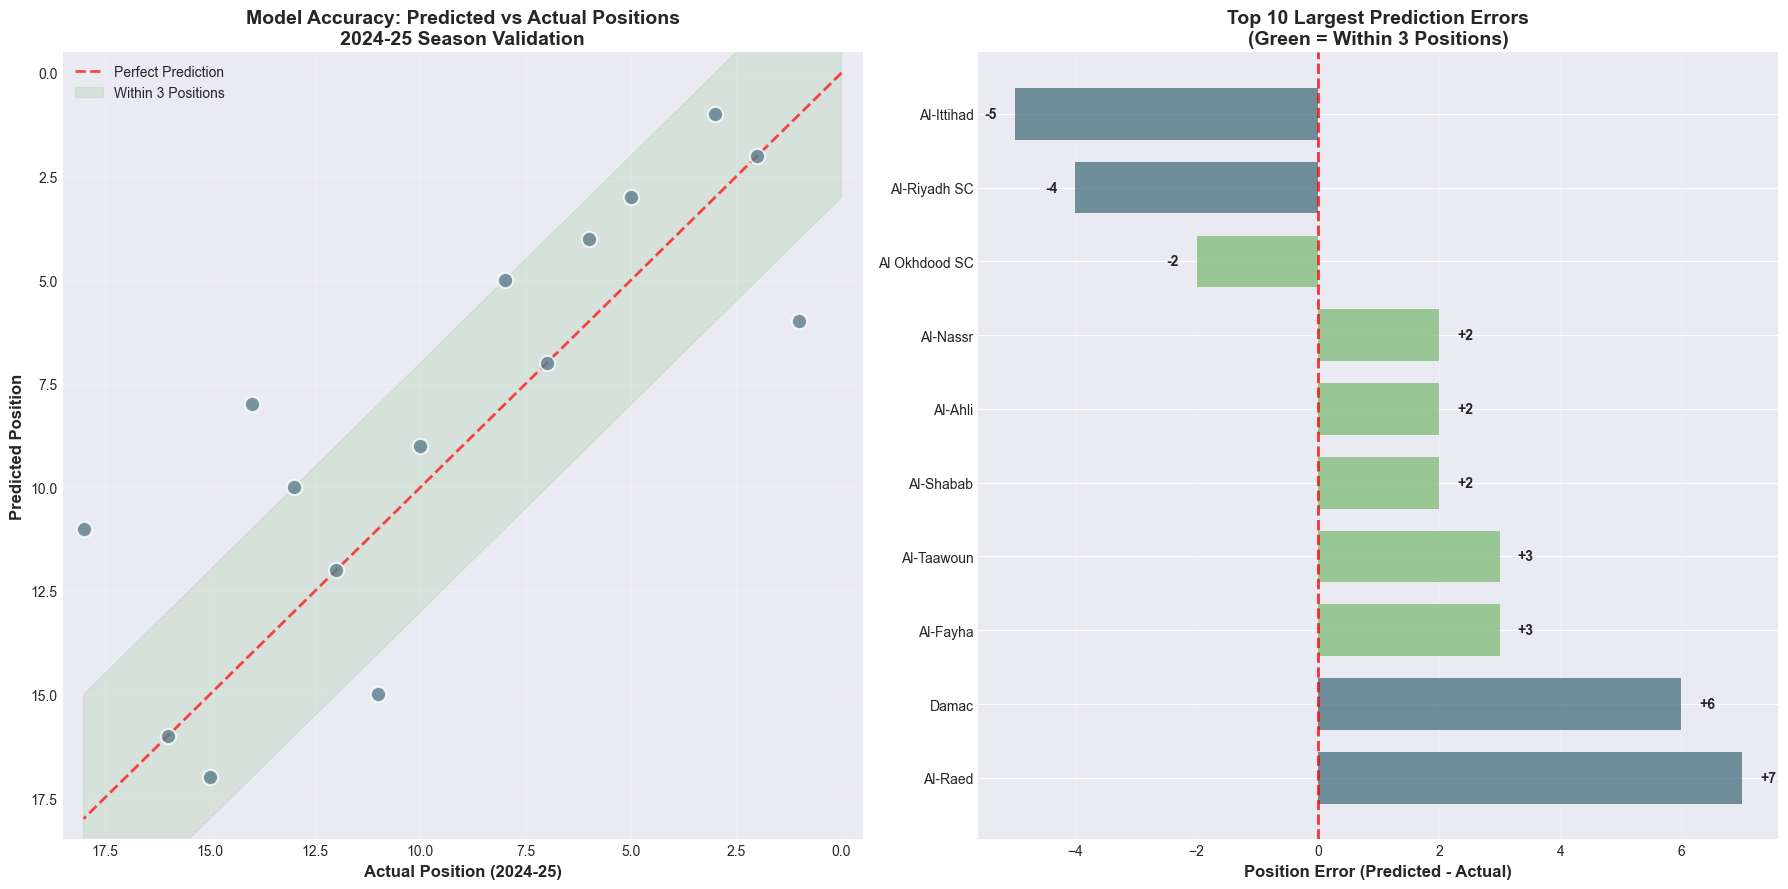

In [38]:
# Use KNN k=7 - our selected best model for detailed analysis
best_model = KNeighborsClassifier(n_neighbors=7)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', best_model)
])
pipeline.fit(X_train_val, y_train_val)
preds_2025 = predict_league_table(pipeline, latest_features_val)

# Merge with Actuals
validation_df = preds_2025.merge(actual_2024_25_summary[['team', 'position', 'points', 'goal_diff']], 
                                  on='team', suffixes=('_pred', '_actual'))
validation_df['error'] = validation_df['position'] - validation_df['predicted_rank']
validation_df['abs_error'] = abs(validation_df['error'])
validation_df = validation_df.sort_values('position')  # Sort by actual position

# Display Detailed Validation Table
print("\n" + "="*100)
print(f"VALIDATION RESULTS: 2024-25 SEASON ({best_model_name})")
print("="*100)
print(f"{'Actual':^6} | {'Predicted':^9} | {'Team':30} | {'Error':6} | {'Points':6} | {'GD':6}")
print("-"*100)

for idx, row in validation_df.iterrows():
    actual_pos = int(row['position'])
    pred_pos = int(row['predicted_rank'])
    error = row['error']
    
    # Color coding based on accuracy
    if error == 0:
        marker = "✓✓"  # Perfect prediction
    elif abs(error) <= 2:
        marker = "✓"   # Close prediction
    elif abs(error) <= 3:
        marker = "~"   # Acceptable
    else:
        marker = "✗"   # Off target
    
    print(f"{actual_pos:^6} | {pred_pos:^9} | {row['team']:30} | {error:+6.0f} {marker} | {row['points']:6.0f} | {row['goal_diff']:+6.0f}")

mae = validation_df['abs_error'].mean()
print("-"*100)
print(f"Mean Absolute Error (MAE): {mae:.2f} positions")
print(f"Perfect Predictions: {len(validation_df[validation_df['error'] == 0])}/{len(validation_df)}")
print(f"Within ±3 Positions: {len(validation_df[validation_df['abs_error'] <= 3])}/{len(validation_df)}")
print("="*100)

# Visualization: Match the style from output.png
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# Chart 1: Scatter Plot - Predicted vs Actual with Perfect Prediction Line
ax1 = axes[0]

# Plot perfect prediction line (diagonal)
max_pos = max(validation_df['position'].max(), validation_df['predicted_rank'].max())
ax1.plot([0, max_pos], [0, max_pos], 'r--', linewidth=2, alpha=0.7, label='Perfect Prediction')

# Add shaded "Within 3 Positions" band
ax1.fill_between([0, max_pos], [0-3, max_pos-3], [0+3, max_pos+3], 
                  color=COLORS['green'], alpha=0.2, label='Within 3 Positions')

# Scatter plot of actual predictions
ax1.scatter(validation_df['position'], validation_df['predicted_rank'], 
            s=120, color='#5a7d8a', alpha=0.8, edgecolors='white', linewidth=1.5, zorder=3)

ax1.set_xlabel('Actual Position (2024-25)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Predicted Position', fontsize=12, fontweight='bold')
ax1.set_title(f'Model Accuracy: Predicted vs Actual Positions\n2024-25 Season Validation', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax1.set_xlim(-0.5, max_pos + 0.5)
ax1.set_ylim(-0.5, max_pos + 0.5)
ax1.invert_xaxis()
ax1.invert_yaxis()

# Chart 2: Top 10 Largest Prediction Errors
ax2 = axes[1]

# Get top 10 errors by absolute value
top_errors = validation_df.nlargest(10, 'abs_error').sort_values('error')

# Color based on whether within 3 positions
error_colors = [COLORS['green'] if abs(e) <= 3 else '#5a7d8a' for e in top_errors['error']]

# Create horizontal bar chart
bars = ax2.barh(top_errors['team'], top_errors['error'], color=error_colors, alpha=0.85, height=0.7)

# Add red dashed line at x=0
ax2.axvline(x=0, color='red', linewidth=2, linestyle='--', alpha=0.8, zorder=2)

# Add value labels on bars
for bar, val in zip(bars, top_errors['error']):
    label_x = val + (0.3 if val > 0 else -0.3)
    ax2.text(label_x, bar.get_y() + bar.get_height()/2, f'{val:+.0f}', 
             va='center', ha='left' if val > 0 else 'right', fontsize=10, fontweight='bold')

ax2.set_xlabel('Position Error (Predicted - Actual)', fontsize=12, fontweight='bold')
ax2.set_title('Top 10 Largest Prediction Errors\n(Green = Within 3 Positions)', 
              fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()



## Validation Table: Side-by-Side Comparison

Comparison of actual 2024-25 final standings with model predictions.


/Users/salmanmo/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/salmanmo/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


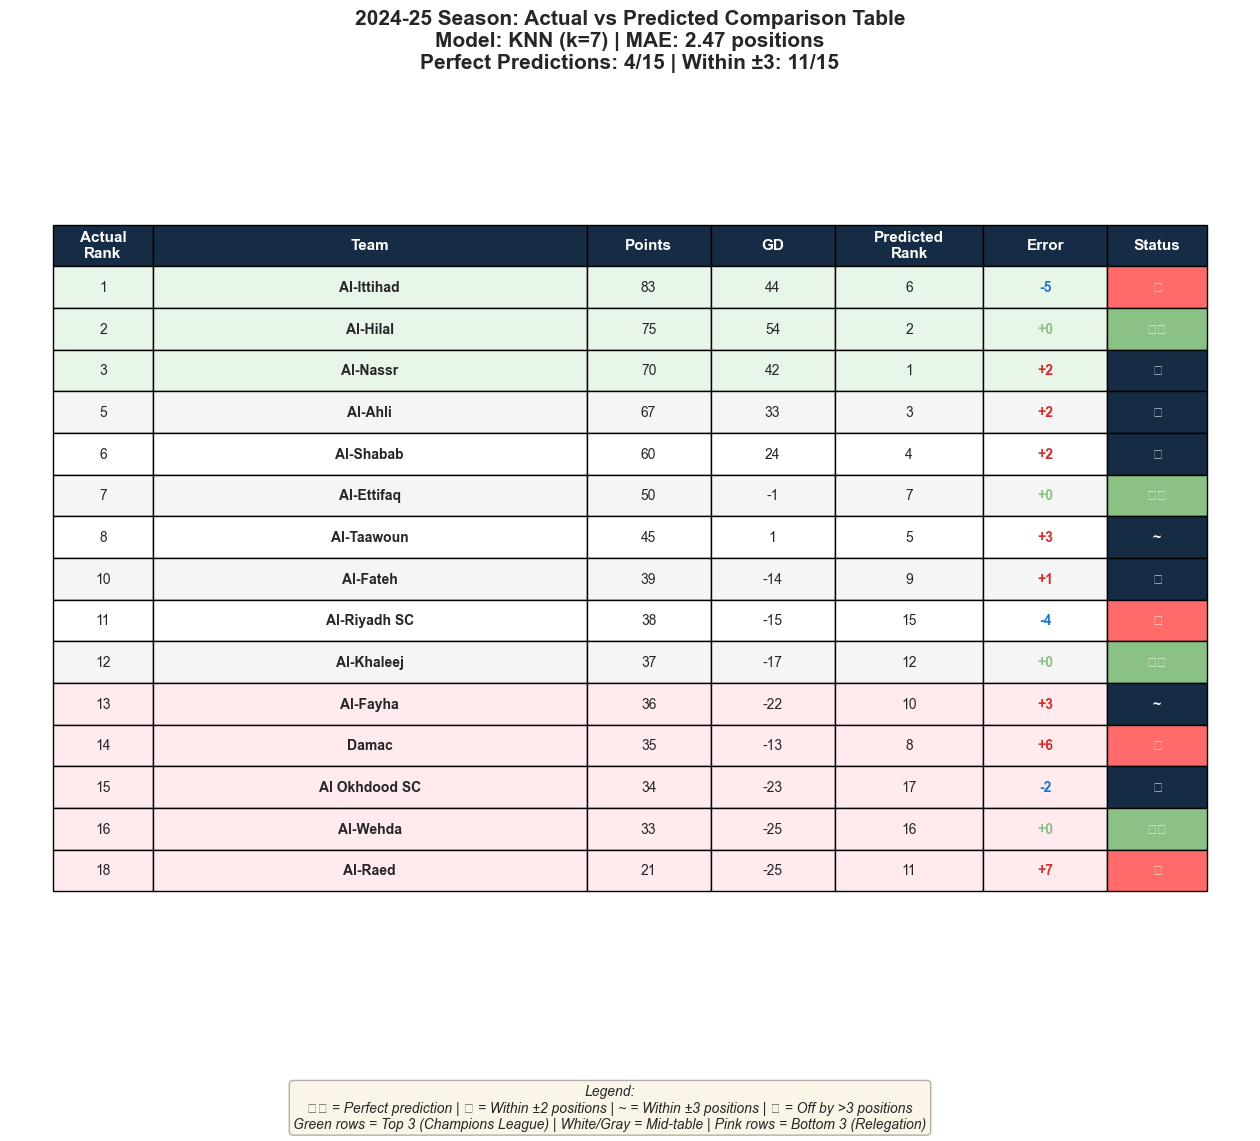

In [39]:
# Create a comprehensive side-by-side comparison table visualization
fig, ax = plt.subplots(figsize=(16, 12))
ax.axis('tight')
ax.axis('off')

# Prepare table data sorted by actual position
comparison_data = []
for _, row in validation_df.iterrows():
    actual_rank = int(row['position'])
    pred_rank = int(row['predicted_rank'])
    error = int(row['error'])
    team = row['team']
    points = int(row['points'])
    gd = int(row['goal_diff'])
    
    # Status indicator
    if error == 0:
        status = "✓✓"
        status_color = COLORS['green']
    elif abs(error) <= 2:
        status = "✓"
        status_color = COLORS['green']
    elif abs(error) <= 3:
        status = "~"
        status_color = COLORS['dark_blue']
    else:
        status = "✗"
        status_color = '#FF6B6B'
    
    comparison_data.append([
        actual_rank, team, points, gd, pred_rank, f"{error:+d}", status
    ])

# Create table
table = ax.table(cellText=comparison_data,
                colLabels=['Actual\nRank', 'Team', 'Points', 'GD', 'Predicted\nRank', 'Error', 'Status'],
                cellLoc='center',
                loc='center',
                colWidths=[0.08, 0.35, 0.1, 0.1, 0.12, 0.1, 0.08])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style header row
for i in range(7):
    cell = table[(0, i)]
    cell.set_facecolor(COLORS['dark_blue'])
    cell.set_text_props(weight='bold', color='white', fontsize=11)

# Style data rows with alternating colors and zone-based coloring
for i, row_data in enumerate(comparison_data, start=1):
    actual_rank = row_data[0]
    error_val = int(row_data[5])
    
    # Determine row background color based on actual position zone
    if actual_rank <= 3:
        row_color = '#e8f5e9'  # Light green for top 3
    elif actual_rank >= len(comparison_data) - 2:
        row_color = '#ffebee'  # Light red for bottom 3
    else:
        row_color = '#f5f5f5' if i % 2 == 0 else 'white'
    
    for j in range(7):
        cell = table[(i, j)]
        cell.set_facecolor(row_color)
        
        # Special styling for status column
        if j == 6:  # Status column
            if abs(error_val) == 0:
                cell.set_facecolor(COLORS['green'])
                cell.set_text_props(color='white', weight='bold')
            elif abs(error_val) <= 3:
                cell.set_facecolor(COLORS['dark_blue'])
                cell.set_text_props(color='white', weight='bold')
            else:
                cell.set_facecolor('#FF6B6B')
                cell.set_text_props(color='white', weight='bold')
        
        # Bold team names
        if j == 1:
            cell.set_text_props(weight='bold')
        
        # Color error values
        if j == 5:
            if error_val > 0:
                cell.set_text_props(color='#d32f2f', weight='bold')
            elif error_val < 0:
                cell.set_text_props(color='#1976d2', weight='bold')
            else:
                cell.set_text_props(color=COLORS['green'], weight='bold')

# Add title
plt.title(f'2024-25 Season: Actual vs Predicted Comparison Table\n' + 
          f'Model: {best_model_name} | MAE: {mae:.2f} positions\n' +
          f'Perfect Predictions: {len(validation_df[validation_df["error"] == 0])}/{len(validation_df)} | ' +
          f'Within ±3: {len(validation_df[validation_df["abs_error"] <= 3])}/{len(validation_df)}',
          fontsize=15, fontweight='bold', pad=20)

# Add legend at bottom
legend_text = (
    'Legend:\n'
    '✓✓ = Perfect prediction | ✓ = Within ±2 positions | ~ = Within ±3 positions | ✗ = Off by >3 positions\n'
    'Green rows = Top 3 (Champions League) | White/Gray = Mid-table | Pink rows = Bottom 3 (Relegation)'
)
plt.figtext(0.5, 0.02, legend_text, ha='center', fontsize=10, 
            style='italic', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.show()


## Final Prediction: 2025/26 Season

Now we apply the **Best Performing Model** trained on **ALL** available history (2018-2025) to predict the future 2025-26 season.



In [40]:
# 1. Prepare FULL dataset (including 2024-25)
all_files = historical_files + ['data/saudi_2024-25.csv']
X_full, y_full, latest_features_2025 = prepare_training_data(all_files)

print(f"Training final model ({best_model_name}) on {len(all_files)} seasons...")

# 2. Train Final Model using KNN k=7
final_model = KNeighborsClassifier(n_neighbors=7)
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', final_model)
])

final_pipeline.fit(X_full, y_full)

# 3. Generate Predictions
predictions_2026 = predict_league_table(final_pipeline, latest_features_2025)

print("Prediction complete.")


Training final model (KNN (k=7)) on 7 seasons...
Prediction complete.


🏆 PREDICTED SAUDI PRO LEAGUE TABLE 2025/26 (KNN (k=7))
 Rank  | Team                           |  Exp. Pos  | Zone                
----------------------------------------------------------------------------------------------------
  1    | Al-Ittihad                     |    1.86    | 🏆 CHAMPION
  2    | Al-Hilal                       |    2.29    | ⭐ AFC Champions League
  3    | Al-Nassr                       |    2.43    | ⭐ AFC Champions League
  4    | Al-Ahli                        |    3.00    |    Mid-Table
  5    | Al-Qadsiah                     |    3.14    |    Mid-Table
  6    | Al-Shabab                      |    4.86    |    Mid-Table
  7    | Al-Ettifaq                     |    5.29    |    Mid-Table
  8    | Al-Taawoun                     |    7.43    |    Mid-Table
  9    | Al-Riyadh SC                   |    8.86    |    Mid-Table
  10   | Damac                          |   11.71    |    Mid-Table
  11   | Al-Fateh                       |   12.00    |    Mid-Table
  

/Users/salmanmo/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


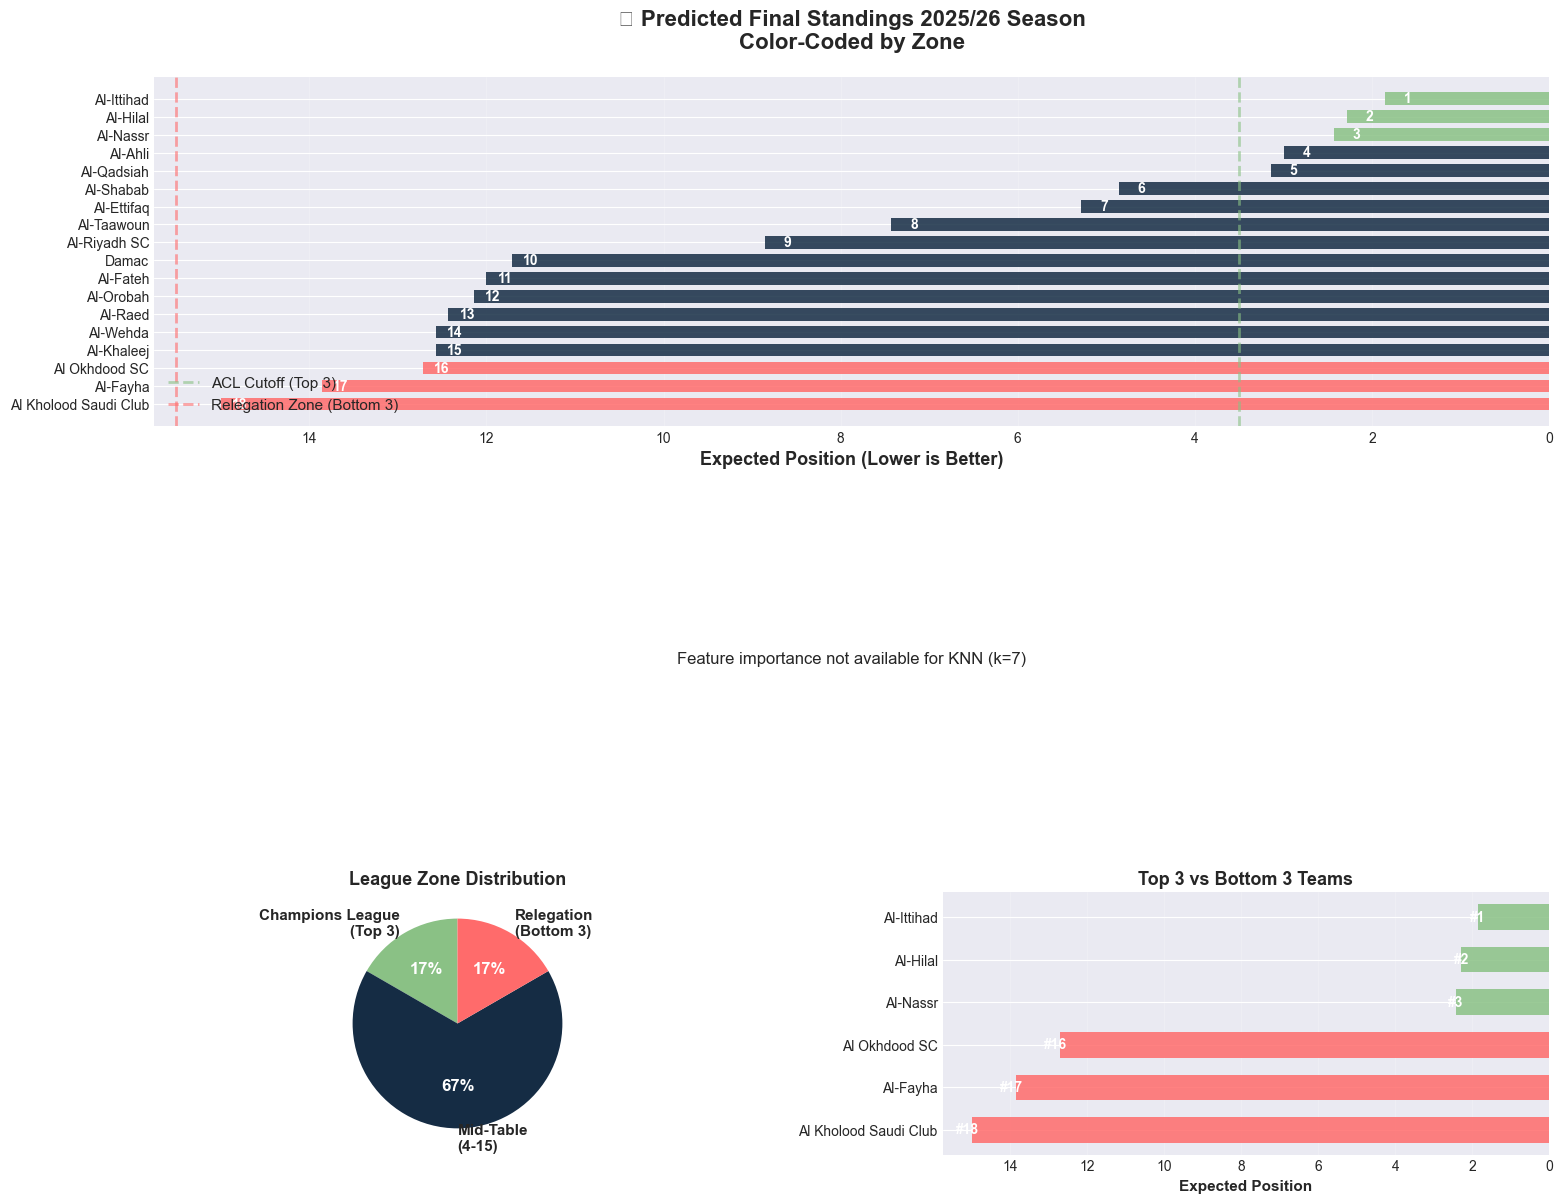


✅ Final 2025-26 predictions complete!


In [41]:
# Display Final Standings with Color-Coded Table
print("="*100)
print(f"🏆 PREDICTED SAUDI PRO LEAGUE TABLE 2025/26 ({best_model_name})")
print("="*100)
print(f"{'Rank':^6} | {'Team':30} | {'Exp. Pos':^10} | {'Zone':20}")
print("-"*100)

table_data = []

for _, row in predictions_2026.iterrows():
    rank = row['predicted_rank']
    team = row['team']
    exp = row['expected_position']
    
    # Determine zone and marker
    if rank == 1:
        marker = "🏆"
        zone = "CHAMPION"
    elif rank <= 3:
        marker = "⭐"
        zone = "AFC Champions League"
    elif rank >= len(predictions_2026)-2:
        marker = "🔻"
        zone = "RELEGATION"
    else:
        marker = "  "
        zone = "Mid-Table"
    
    print(f"{rank:^6} | {team:30} | {exp:^10.2f} | {marker} {zone}")
    
    # Prepare data for visual table
    table_data.append([rank, team, exp, zone])

print("="*100)

# Create comprehensive visualization with 3 charts
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 2, height_ratios=[2, 1.5, 1.5], hspace=0.35, wspace=0.3)

# Chart 1: Color-Coded Final Table (Full Width)
ax1 = fig.add_subplot(gs[0, :])

# Sort by predicted rank
predictions_2026_sorted = predictions_2026.sort_values('predicted_rank')

# Define colors for zones
bar_colors = []
for i, rank in enumerate(predictions_2026_sorted['predicted_rank']):
    if rank <= 3:
        bar_colors.append(COLORS['green'])  # Champions League
    elif rank >= len(predictions_2026_sorted) - 2:
        bar_colors.append('#FF6B6B')  # Relegation
    else:
        bar_colors.append(COLORS['dark_blue'])  # Mid-table

# Create horizontal bar chart
bars = ax1.barh(predictions_2026_sorted['team'], predictions_2026_sorted['expected_position'], 
                color=bar_colors, alpha=0.85, height=0.7)

ax1.set_xlabel('Expected Position (Lower is Better)', fontsize=13, fontweight='bold')
ax1.set_title('🏆 Predicted Final Standings 2025/26 Season\nColor-Coded by Zone', 
              fontsize=16, fontweight='bold', pad=20)
ax1.invert_yaxis()
ax1.invert_xaxis()  # So position 1 is on the right

# Add vertical lines for zone boundaries
ax1.axvline(x=3.5, color=COLORS['green'], linestyle='--', linewidth=2, alpha=0.6, label='ACL Cutoff (Top 3)')
ax1.axvline(x=len(predictions_2026_sorted)-2.5, color='#FF6B6B', linestyle='--', linewidth=2, alpha=0.6, 
            label='Relegation Zone (Bottom 3)')

# Add value labels on bars
for bar, val, rank in zip(bars, predictions_2026_sorted['expected_position'], 
                          predictions_2026_sorted['predicted_rank']):
    ax1.text(val - 0.3, bar.get_y() + bar.get_height()/2, f'{int(rank)}', 
             va='center', ha='right', fontsize=10, fontweight='bold', color='white')

ax1.legend(loc='lower left', fontsize=11, framealpha=0.9)
ax1.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)

# Chart 2: Feature Importance (Only if Random Forest or Tree-based)
ax2 = fig.add_subplot(gs[1, :])

if hasattr(final_pipeline.named_steps['classifier'], 'feature_importances_'):
    importances = pd.DataFrame({
        'Feature': ['Points', 'Wins', 'Draws', 'Losses', 'Goals For', 'Goals Against', 'Goal Diff'],
        'Importance': final_pipeline.named_steps['classifier'].feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Create gradient colors
    importance_colors = [COLORS['green'] if imp == importances['Importance'].max() 
                        else COLORS['dark_blue'] for imp in importances['Importance']]
    
    bars2 = ax2.barh(importances['Feature'], importances['Importance'], 
                     color=importance_colors, alpha=0.85, height=0.6)
    
    # Add value labels
    for bar, val in zip(bars2, importances['Importance']):
        ax2.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
                 va='center', ha='left', fontsize=10, fontweight='bold')
    
    ax2.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
    ax2.set_title('📊 Feature Importance - What Drives the Predictions?', 
                  fontsize=14, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
else:
    ax2.text(0.5, 0.5, f'Feature importance not available for {best_model_name}', 
             ha='center', va='center', fontsize=12)
    ax2.axis('off')

# Chart 3: Zone Distribution Pie Chart
ax3 = fig.add_subplot(gs[2, 0])

zone_counts = {
    'Champions League\n(Top 3)': 3,
    'Mid-Table\n(4-15)': len(predictions_2026) - 6,
    'Relegation\n(Bottom 3)': 3
}

colors_pie = [COLORS['green'], COLORS['dark_blue'], '#FF6B6B']
wedges, texts, autotexts = ax3.pie(zone_counts.values(), labels=zone_counts.keys(), 
                                     autopct='%1.0f%%', startangle=90, colors=colors_pie,
                                     textprops={'fontsize': 11, 'fontweight': 'bold'})

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)

ax3.set_title('League Zone Distribution', fontsize=13, fontweight='bold')

# Chart 4: Top vs Bottom Teams - Expected Position Comparison
ax4 = fig.add_subplot(gs[2, 1])

top_3 = predictions_2026_sorted.head(3)
bottom_3 = predictions_2026_sorted.tail(3)

combined = pd.concat([top_3, bottom_3])
combined_colors = [COLORS['green']] * 3 + ['#FF6B6B'] * 3

bars4 = ax4.barh(range(len(combined)), combined['expected_position'], 
                 color=combined_colors, alpha=0.85, height=0.6)

ax4.set_yticks(range(len(combined)))
ax4.set_yticklabels(combined['team'], fontsize=10)
ax4.set_xlabel('Expected Position', fontsize=11, fontweight='bold')
ax4.set_title('Top 3 vs Bottom 3 Teams', fontsize=13, fontweight='bold')
ax4.invert_yaxis()
ax4.invert_xaxis()
ax4.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)

# Add rank labels
for i, (bar, rank) in enumerate(zip(bars4, combined['predicted_rank'])):
    ax4.text(bar.get_width() - 0.2, bar.get_y() + bar.get_height()/2, f'#{int(rank)}', 
             va='center', ha='right', fontsize=10, fontweight='bold', color='white')

plt.suptitle('', fontsize=1)  # Remove default title
plt.show()

print("\n✅ Final 2025-26 predictions complete!")



## 📊 Executive Summary: 2024-25 Validation vs 2025-26 Predictions

A comprehensive comparison showing model performance on known data and future predictions.


/Users/salmanmo/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


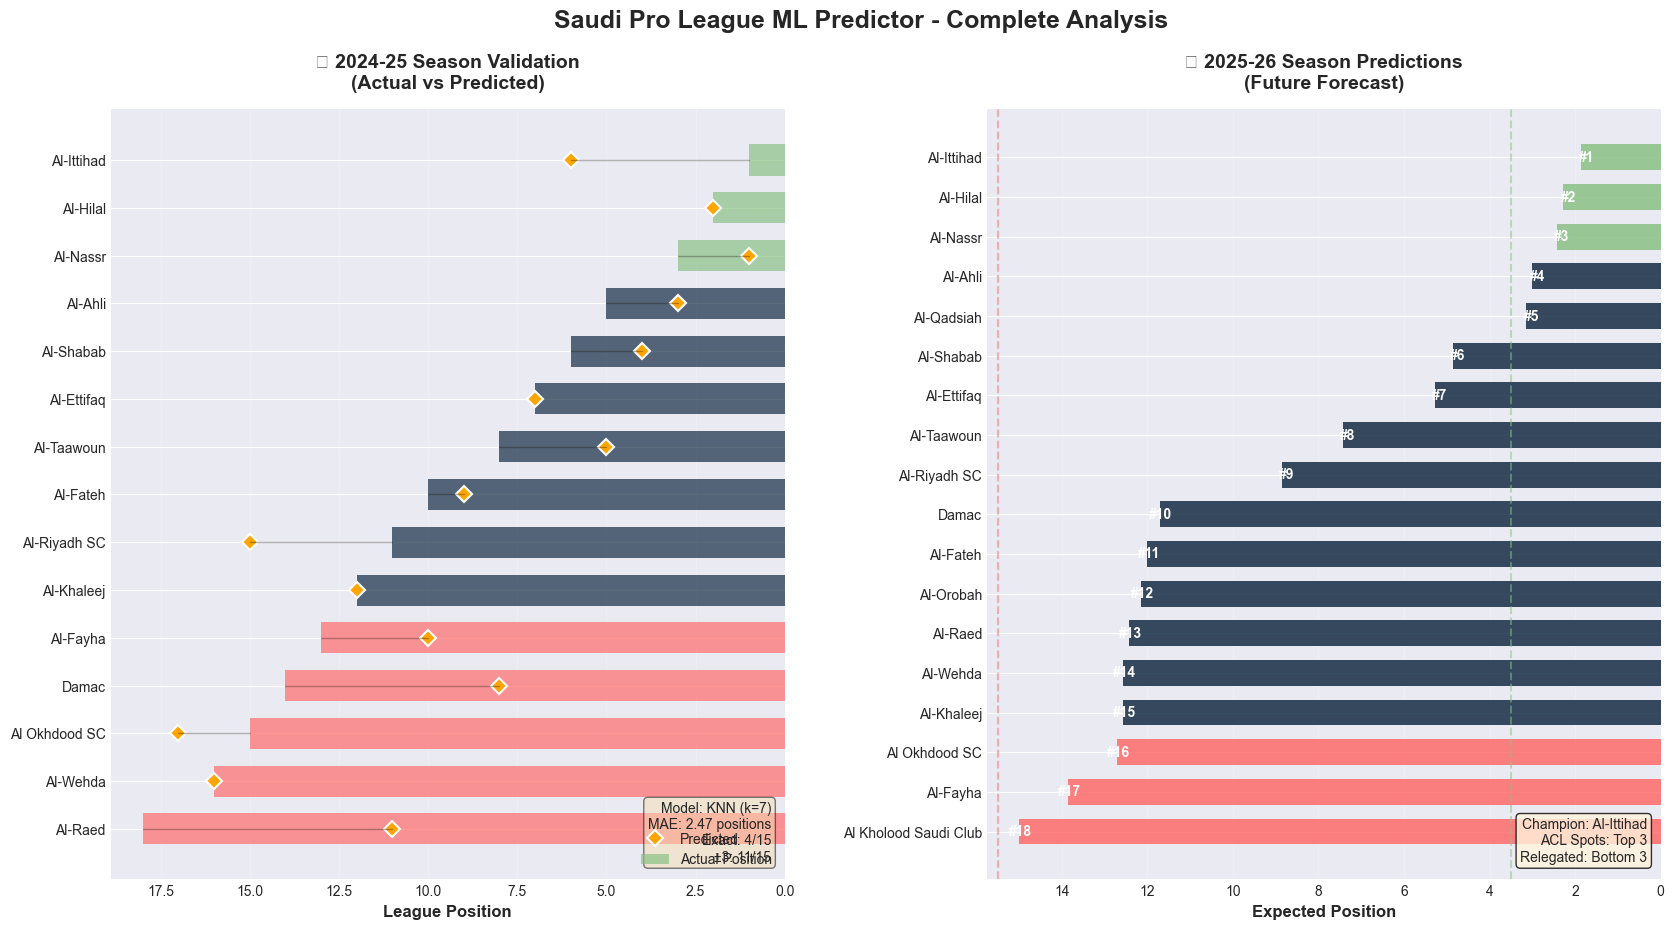


🎯 ANALYSIS COMPLETE
✅ Validated on 2024-25 season with KNN (k=7)
   - Mean Absolute Error: 2.47 positions
   - Predictions within ±3 positions: 11/15 (73.3%)

🔮 2025-26 Season Predictions:
   - Predicted Champion: Al-Ittihad
   - ACL Qualifiers: Al-Ittihad, Al-Hilal, Al-Nassr
   - Relegation Zone: Al Okhdood SC, Al-Fayha, Al Kholood Saudi Club


In [42]:
# Create comprehensive side-by-side summary
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 2, wspace=0.3)

# Left: 2024-25 Validation Results
ax1 = fig.add_subplot(gs[0, 0])

# Prepare validation data
val_sorted = validation_df.sort_values('position')
val_colors = []
for rank in val_sorted['position']:
    if rank <= 3:
        val_colors.append(COLORS['green'])
    elif rank >= len(val_sorted) - 2:
        val_colors.append('#FF6B6B')
    else:
        val_colors.append(COLORS['dark_blue'])

# Plot actual positions
bars1 = ax1.barh(val_sorted['team'], val_sorted['position'], 
                 color=val_colors, alpha=0.7, height=0.65, label='Actual Position')

# Overlay predicted positions as markers
for idx, row in val_sorted.iterrows():
    ax1.plot(row['predicted_rank'], row['team'], 'D', color='orange', 
             markersize=8, markeredgecolor='white', markeredgewidth=1.5, 
             label='Predicted' if row['team'] == val_sorted.iloc[0]['team'] else '')

ax1.set_xlabel('League Position', fontsize=12, fontweight='bold')
ax1.set_title('📋 2024-25 Season Validation\n(Actual vs Predicted)', 
              fontsize=14, fontweight='bold', pad=15)
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
ax1.legend(loc='lower right', fontsize=10)

# Add error indicators
for idx, row in val_sorted.iterrows():
    error = row['error']
    if abs(error) > 0:
        # Draw line connecting actual to predicted
        ax1.plot([row['position'], row['predicted_rank']], [row['team'], row['team']], 
                'k-', alpha=0.3, linewidth=1)

# Add statistics box
stats_text = (f"Model: {best_model_name}\n"
              f"MAE: {mae:.2f} positions\n"
              f"Exact: {len(validation_df[validation_df['error'] == 0])}/{len(validation_df)}\n"
              f"±3: {len(validation_df[validation_df['abs_error'] <= 3])}/{len(validation_df)}")
ax1.text(0.98, 0.02, stats_text, transform=ax1.transAxes, 
         fontsize=10, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Right: 2025-26 Predictions
ax2 = fig.add_subplot(gs[0, 1])

# Plot predicted 2025-26 standings
pred_colors = []
for rank in predictions_2026_sorted['predicted_rank']:
    if rank <= 3:
        pred_colors.append(COLORS['green'])
    elif rank >= len(predictions_2026_sorted) - 2:
        pred_colors.append('#FF6B6B')
    else:
        pred_colors.append(COLORS['dark_blue'])

bars2 = ax2.barh(predictions_2026_sorted['team'], predictions_2026_sorted['expected_position'],
                 color=pred_colors, alpha=0.85, height=0.65)

# Add rank labels on bars
for bar, rank in zip(bars2, predictions_2026_sorted['predicted_rank']):
    ax2.text(bar.get_width() - 0.3, bar.get_y() + bar.get_height()/2, 
             f'#{int(rank)}', va='center', ha='right', 
             fontsize=10, fontweight='bold', color='white')

ax2.set_xlabel('Expected Position', fontsize=12, fontweight='bold')
ax2.set_title('🏆 2025-26 Season Predictions\n(Future Forecast)', 
              fontsize=14, fontweight='bold', pad=15)
ax2.invert_xaxis()
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)

# Add zone lines
ax2.axvline(x=3.5, color=COLORS['green'], linestyle='--', linewidth=1.5, alpha=0.5)
ax2.axvline(x=len(predictions_2026_sorted)-2.5, color='#FF6B6B', linestyle='--', linewidth=1.5, alpha=0.5)

# Add prediction info box
pred_text = (f"Champion: {predictions_2026_sorted.iloc[0]['team']}\n"
             f"ACL Spots: Top 3\n"
             f"Relegated: Bottom 3")
ax2.text(0.98, 0.02, pred_text, transform=ax2.transAxes, 
         fontsize=10, verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor=COLORS['cream'], alpha=0.8))

plt.suptitle('Saudi Pro League ML Predictor - Complete Analysis', 
             fontsize=18, fontweight='bold', y=0.98)

plt.show()

# Print final summary
print("\n" + "="*100)
print("🎯 ANALYSIS COMPLETE")
print("="*100)
print(f"✅ Validated on 2024-25 season with {best_model_name}")
print(f"   - Mean Absolute Error: {mae:.2f} positions")
print(f"   - Predictions within ±3 positions: {len(validation_df[validation_df['abs_error'] <= 3])}/{len(validation_df)} ({len(validation_df[validation_df['abs_error'] <= 3])/len(validation_df)*100:.1f}%)")
print(f"\n🔮 2025-26 Season Predictions:")
print(f"   - Predicted Champion: {predictions_2026_sorted.iloc[0]['team']}")
print(f"   - ACL Qualifiers: {', '.join(predictions_2026_sorted.head(3)['team'].tolist())}")
print(f"   - Relegation Zone: {', '.join(predictions_2026_sorted.tail(3)['team'].tolist())}")
print("="*100)
